## Dependancies and Imports

In [1]:
!pip install -r ../requirements.txt
# !pip install googletrans==3.1.0a0
# !pip install --upgrade transformers

In [2]:
import datetime
import pandas as pd
from sklearn import metrics
import time
import torch
from torch.utils.data import TensorDataset, DataLoader, Dataset
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence, pad_sequence
from torchvision import models
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from tqdm import tqdm

pd.set_option("display.max_columns", None)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Load Data and Data Preprocessing

In [4]:
# df = pd.read_csv("./drive/MyDrive/CSC413_data/leetcode.csv")
df = pd.read_csv("../data_preprocessing/data_raw/leetcode_dataset - lc.csv")
## drop sql schema
df.drop(df[df.description.str.contains("SQL Schema")].index, inplace=True)
## drop nan in related_topics
df.dropna(subset=["related_topics"], inplace=True)
## lower case all description
df["description"] = df["description"].str.lower()
## split related_topics
df["related_topics"] = df["related_topics"].str.split(",")
df.sample(10)

,id,title,description,is_premium,difficulty,solution_link,acceptance_rate,frequency,url,discuss_count,accepted,submissions,companies,related_topics,likes,dislikes,rating,asked_by_faang,similar_questions
1090,1091,Shortest Path in Binary Matrix,"given an `n x n` binary matrix `grid`, return ...",0,Medium,/articles/shortest-path-in-a-binary-matrix,40.2,54.1,https://leetcode.com/problems/shortest-path-in...,573,83K,206.5K,"Amazon,Google,Facebook,Oracle,Snapchat",[Breadth-first Search],1144,75,94,1,NaN
779,780,Reaching Points,"a move consists of taking a point `(x, y)` and...",0,Hard,/articles/reaching-points,30.4,64.1,https://leetcode.com/problems/reaching-points,110,31K,101.9K,"Twitter,Goldman Sachs",[Math],713,128,85,0,NaN
738,739,Daily Temperatures,"given a list of daily temperatures `t`, return...",0,Medium,/articles/daily-temperatures,64.8,73.7,https://leetcode.com/problems/daily-temperatures,960,232K,357.9K,"Facebook,Bloomberg,Amazon,ByteDance,Google,Ado...","[Hash Table, Stack]",4052,124,97,1,"[Next Greater Element I, /problems/next-greate..."
1722,1723,Find Minimum Time to Finish All Jobs,"you are given an integer array `jobs`, where `...",0,Hard,NaN,43.7,5.7,https://leetcode.com/problems/find-minimum-tim...,77,7.7K,17.6K,Amazon,"[Backtracking, Recursion]",211,10,95,1,NaN
1128,1129,Shortest Path with Alternating Colors,"consider a directed graph, with nodes labelled...",0,Medium,NaN,40.5,5.0,https://leetcode.com/problems/shortest-path-wi...,304,21.9K,54.2K,Amazon,"[Breadth-first Search, Graph]",651,37,95,1,NaN
1761,1762,Buildings With an Ocean View,there are `n` buildings in a line. you are giv...,1,Medium,NaN,80.7,17.5,https://leetcode.com/problems/buildings-with-a...,121,4.3K,5.4K,Facebook,[Greedy],70,13,84,1,NaN
1154,1155,Number of Dice Rolls With Target Sum,"you have `d` dice, and each die has `f` faces ...",0,Medium,NaN,47.6,27.6,https://leetcode.com/problems/number-of-dice-r...,470,68.4K,143.7K,"Amazon,Microsoft,ByteDance",[Dynamic Programming],1230,59,95,1,[Equal Sum Arrays With Minimum Number of Opera...
1062,1063,Number of Valid Subarrays,"given an array `a` of integers, return the num...",1,Hard,NaN,72.1,8.8,https://leetcode.com/problems/number-of-valid-...,83,4.7K,6.5K,Hulu,[Stack],126,8,94,0,NaN
985,986,Interval List Intersections,"you are given two lists of closed intervals, `...",0,Medium,/articles/interval-list-intersections,68.5,61.4,https://leetcode.com/problems/interval-list-in...,839,175.7K,256.4K,"Facebook,Uber,Apple,Google,Amazon,Bloomberg",[Two Pointers],2170,60,97,1,"[Merge Intervals, /problems/merge-intervals/, ..."
886,887,Super Egg Drop,you are given `k` identical eggs and you have ...,0,Hard,/articles/super-egg-drop,27.0,42.2,https://leetcode.com/problems/super-egg-drop,121,28.8K,106.7K,Amazon,"[Math, Binary Search, Dynamic Programming]",1332,96,93,1,NaN


In [5]:
inputs = df["description"].values
labels_ori = df['related_topics'].values
print(inputs[0])
print(labels_ori[0])
print(len(inputs))

given an array of integers `nums` and an integer `target`, return indices of the two numbers such that they add up to `target`.

you may assume that each input would have exactly one solution, and you may not use the same element twice.

you can return the answer in any order.


example 1:
input: nums = [2,7,11,15], target = 9
output: [0,1]
output: because nums[0] + nums[1] == 9, we return [0, 1].

example 2:
input: nums = [3,2,4], target = 6
output: [1,2]

example 3:
input: nums = [3,3], target = 6
output: [0,1]

constraints:
`2 <= nums.length <= 103`
`-109 <= nums[i] <= 109`
`-109 <= target <= 109`
only one valid answer exists.
['Array', 'Hash Table']
1571


In [6]:
## label tags to binary
mlb = MultiLabelBinarizer()
labels = mlb.fit_transform(labels_ori)
print(labels[0])
print(mlb.inverse_transform(labels[0].reshape(1,-1)))
print(mlb.classes_)

[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0]
[('Array', 'Hash Table')]
['Array' 'Backtracking' 'Binary Indexed Tree' 'Binary Search'
 'Binary Search Tree' 'Bit Manipulation' 'Brainteaser'
 'Breadth-first Search' 'Depth-first Search' 'Dequeue' 'Design'
 'Divide and Conquer' 'Dynamic Programming' 'Geometry' 'Graph' 'Greedy'
 'Hash Table' 'Heap' 'Line Sweep' 'Linked List' 'Math'
 'Meet in the Middle' 'Memoization' 'Minimax' 'OOP' 'Ordered Map' 'Queue'
 'Random' 'Recursion' 'Rejection Sampling' 'Reservoir Sampling'
 'Rolling Hash' 'Segment Tree' 'Sliding Window' 'Sort' 'Stack' 'String'
 'Suffix Array' 'Topological Sort' 'Tree' 'Trie' 'Two Pointers'
 'Union Find']


(array([ 3., 15., 27., 44., 51., 66., 74., 62., 79., 85., 67., 63., 87.,
        67., 73., 58., 71., 48., 52., 43., 44., 42., 37., 42., 35., 19.,
        25., 18., 22., 13., 16., 18.,  8., 10.,  7.,  6.,  8.,  8.,  4.,
        10.,  2.,  6.,  3.,  1.,  4.,  1.,  0.,  1.,  4.,  1.,  1.,  1.,
         1.,  2.,  1.,  2.,  0.,  0.,  2.,  1.,  0.,  0.,  0.,  1.,  1.,
         1.,  2.,  0.,  0.,  2.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([ 34.  ,  42.91,  51.82,  60.73,  69.64,  78.55,  87.46,  96.37,
        105.28, 114.19, 123.1 , 132.01, 140.92, 149.83, 158.74, 167.65,
        176.56, 185.47, 194.38, 203.29, 212.2 , 221.11, 230.02, 238.93,
        247.84, 256.75, 265.66, 274.57, 283.48, 292.39, 301.3 , 310.21,
        319.12, 328.03, 336.94, 345.85, 354.76, 363.67, 372.58, 381.49,
        390.4 , 399.31, 408.22, 417.13, 426.04, 434.95, 443.86, 452.77,
  

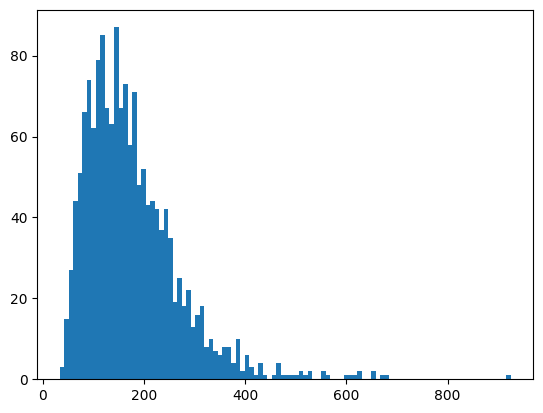

In [7]:
## check the distribution of length of inputs
inputs_len = [len(i.split()) for i in inputs]
plt.hist(inputs_len, bins=100)

In [8]:
# hyperparameters
MAX_LEN = 512
num_labels = len(mlb.classes_)
batch_size = 8
LEARNING_RATE = 2e-5

In [9]:
## word embedding using glove
import torch.nn as nn
from torchtext.vocab import GloVe

# load the pre-trained GloVe model with 100-dimensional embeddings
glove = GloVe(name='6B', dim=300)

# set the maximum length of the input strings
max_length = 100

# define the embedding layer
embedding_layer = nn.Embedding(len(glove.itos), 300)
embedding_layer.weight.data.copy_(glove.vectors)

# define a function to convert input strings into numerical vectors
def tokenizer(text):

    # split the input string into individual words
    words = text.split()
    
    # initialize a temporary list to hold the indices of all words in the input string
    indices = []
    
    # loop over each word in the input string
    for word in words:
        # if the word is not in the pre-trained GloVe model, skip it
        if word not in glove.stoi:
            continue
            
        # look up the index of the word in the pre-trained GloVe model
        index = glove.stoi[word]
        
        # add the index to the temporary list
        indices.append(index)
    
    # pad the list of indices with zeros to make it the same length as the maximum length
    indices += [0] * (max_length - len(indices))
    
    # convert the list of indices into a PyTorch tensor
    indices_tensor = torch.tensor(indices)
    
    # convert the tensor of indices into a tensor of numerical vectors using the embedding layer
    vector_tensor = embedding_layer(indices_tensor).mean(dim=0)

    # stack the list of numerical vectors into a PyTorch tensor of shape (num_inputs, 300)
    return vector_tensor

print(tokenizer(inputs[0]))


tensor([-1.1476e-01,  1.8802e-01, -3.7333e-02, -2.0750e-01, -1.4193e-01,
         9.4439e-02, -1.0180e-01,  1.2715e-01, -3.6650e-02, -1.5465e+00,
        -1.4673e-02,  1.1268e-01, -7.7418e-02,  5.1625e-02,  1.7759e-02,
         1.1689e-01, -1.6060e-01, -7.7406e-02, -1.1853e-01, -1.1082e-01,
        -1.5944e-01,  7.2837e-02,  2.2259e-01,  6.7503e-02, -6.9378e-02,
        -7.8875e-02,  4.6822e-02, -7.5216e-03, -1.6564e-01, -1.0504e-02,
         3.8817e-02,  2.3384e-01, -2.5660e-01,  9.9788e-02, -7.0982e-01,
        -2.7969e-02,  1.5173e-01, -4.1461e-02, -1.0999e-01,  1.2725e-01,
         3.9070e-02, -1.0160e-01, -1.5435e-01,  2.5016e-01,  8.5946e-02,
         7.8045e-02,  6.6252e-02,  1.0102e-01, -1.8427e-01,  6.0424e-02,
         1.6211e-01, -7.6610e-02,  1.5551e-02, -5.4577e-02, -8.9845e-02,
         2.0722e-01, -5.5075e-02,  1.9141e-01,  1.3444e-01,  5.4440e-02,
         7.9659e-02,  4.9190e-02,  1.8300e-01, -6.5080e-02, -4.5392e-02,
        -3.4303e-01,  1.0437e-01,  5.0513e-02,  7.2

### Data Augmentation

In [10]:
def vectorize_input_data(input_data):
    # initialize an empty array to hold the numerical vectors
    vectorized_data = []
    
    # loop over each input string
    for input_string in input_data:
        # split the input string into individual words
        words = input_string
        
        # initialize a temporary list to hold the indices of all words in the input string
        indices = []
        
        # loop over each word in the input string
        for word in words:
            # if the word is not in the pre-trained GloVe model, skip it
            if word not in glove.stoi:
                continue
                
            # look up the index of the word in the pre-trained GloVe model
            index = glove.stoi[word]
            
            # add the index to the temporary list
            indices.append(index)
        
        # pad the list of indices with zeros to make it the same length as the maximum length
        indices += [0] * (max_length - len(indices))
        
        # convert the list of indices into a PyTorch tensor
        indices_tensor = torch.tensor(indices)
        
        # convert the tensor of indices into a tensor of numerical vectors using the embedding layer
        vector_tensor = embedding_layer(indices_tensor).mean(dim=0)
        
        # append the numerical vector to the list of vectorized input data
        vectorized_data.append(vector_tensor)
    
    # stack the list of numerical vectors into a PyTorch tensor of shape (num_inputs, 100)
    return torch.stack(vectorized_data)
inputs = vectorize_input_data(labels_ori)

In [11]:
# data augmentation
from googletrans import Translator
translator = Translator()
def transform(text):
    # randomly select a language to translate to
    lang = np.random.choice(['fr', 'zh-cn', 'es', 'de', 'ru', 'ja', 'ko'])
    translated = translator.translate(text, dest=lang)
    # then translate back to english
    translated = translator.translate(translated.text, dest='en')
    return translated.text

In [12]:
class BERTDataset(Dataset):
    def __init__(self, inputs, tags, transform):
        self.labels = torch.tensor(tags, dtype=torch.float).to(device)
        self.data = pad_sequence(inputs, batch_first=True).to(device)
        self.lens = [len(i) for i in inputs]
        self.transform = transform

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        # text = self.texts[index]
        # text = self.transform(text)
        # inputs = tokenizer(text)
        # labels = torch.tensor(self.labels[index], dtype=torch.float)
        return self.data[index], self.labels[index], self.lens[index]

In [13]:
def data_split(inputs, labels, test_size=0.2, random_state=42, tokenizer=None, MAX_LEN=512, transform=None, batch_size=32):
    inputs_train, inputs_test, labels_train, labels_test = train_test_split(inputs, labels, test_size=0.2, random_state=42, shuffle=True)
    inputs_train, inputs_val, labels_train, labels_val = train_test_split(inputs_train, labels_train, test_size=0.2, random_state=42, shuffle=True)
    train = BERTDataset(inputs_train, labels_train, transform)
    val = BERTDataset(inputs_val, labels_val, transform)
    test = BERTDataset(inputs_test, labels_test, transform)
    train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val, batch_size=batch_size)
    test_loader = DataLoader(test, batch_size=batch_size)
    return train_loader, val_loader, test_loader

In [14]:
train_loader, val_loader, test_loader = data_split(inputs, labels, MAX_LEN=MAX_LEN, transform=transform, batch_size=batch_size)

### Model && Utils

In [15]:
class LSTMClass(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size, lstm_model=None):
        super().__init__()
        if lstm_model is None:
            self.lstm_model = torch.nn.LSTM(input_size, hidden_size)
        else:
            self.lstm_model = lstm_model
        self.fc = torch.nn.Sequential(
            torch.nn.Linear(hidden_size, output_size),
        )
        self.loss = torch.nn.BCELoss()
    
    def forward(self, inputs, labels):
        lstm_output, (ht, ct) = self.lstm_model(inputs)
        output = self.fc(lstm_output)
        loss = self.loss(output, labels)
        return output, loss


In [16]:
def format_time(elapsed):
    elapsed_rounded = int(round(elapsed, 2))
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [17]:
def validation(valid_loader, model, epoch):
    model.eval()
    total_loss = 0.0
    cnt = 0
    fin_targets=[]
    fin_outputs=[]
    t0 = time.time()
    with tqdm(valid_loader, unit="batch") as train_pbar:
        for data in train_pbar:
            train_pbar.set_description(f"Training (epoch {epoch + 1})")
            inputs, labels, lens = data
            with torch.no_grad():
                outputs, loss = model(inputs, labels)
                total_loss += loss.item()
                cnt += 1
                fin_targets.extend(labels.cpu().detach().numpy().tolist())
                fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
    outputs = np.array(fin_outputs) >= 0.5
    accuracy = metrics.accuracy_score(np.array(fin_targets), outputs)
    print("  * Average validation loss: {0:.2f}".format(total_loss/cnt))
    print("  * Accuracy: {0:.2f}".format(accuracy))
    print("  * Validation took: {:}".format(format_time(time.time() - t0)))
    return accuracy, total_loss/cnt

In [18]:
def train(train_loader, model, epoch):
    total_loss = 0.0
    cnt = 0
    model.train()
    t0 = time.time()
    with tqdm(train_loader, unit="batch") as train_pbar:
        for data in train_pbar:
            train_pbar.set_description(f"Training (epoch {epoch + 1})")
            inputs, labels, lens = data
            outputs, loss = model(inputs, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            total_loss += loss.item()
            cnt += 1
    train_loss = total_loss/cnt
    print("  * Average training loss: {0:.2f}".format(train_loss))
    print("  * Training epoch took: {:}".format(format_time(time.time() - t0)))
    print("Running Validation...")
    
    return train_loss

In [19]:
def train_epoch(epochs, train_loader,valid_loader, model):
    train_losses = []
    val_losses = []
    accuracies = []
    for epoch in range(epochs):
        print(f'Epoch {epoch+1}/{epochs}')
        train_loss = train(train_loader, model, epoch)
        accuracy, val_loss = validation(valid_loader, model, epoch)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        accuracies.append(accuracy)
    return train_losses, val_losses, accuracies

In [20]:
def plot_loss_and_acc(loss_vals, eval_accs):
    sns.set(style='darkgrid')
    sns.set(font_scale=1.5)
    plt.rcParams["figure.figsize"] = (12,6)
    fig, ax1 = plt.subplots(1,1)
    ax1.plot(loss_vals, 'b-o', label = 'training loss')
    ax2 = ax1.twinx()
    ax2.plot(eval_accs, 'y-o', label = 'validation accuracy')
    ax2.set_title("Training loss and validation accuracy")
    ax2.set_xlabel("Epoch")
    ax1.set_ylabel("Loss", color='b')
    ax2.set_ylabel("Accuracy", color='y')
    ax1.tick_params(axis='y', rotation=0, labelcolor='b' )
    ax2.tick_params(axis='y', rotation=0, labelcolor='y' )
    plt.show()

### Training

In [21]:
model = LSTMClass(input_size=300, hidden_size=128, output_size=num_labels)
model.to(device)

LSTMClass(
  (lstm_model): LSTM(300, 128)
  (fc): Sequential(
    (0): Linear(in_features=128, out_features=43, bias=True)
  )
  (loss): BCELoss()
)

In [22]:
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-2)

In [23]:
EPOCHS = 3

train_losses, val_losses, accuracies = train_epoch(EPOCHS, train_loader, val_loader, model)

Epoch 1/3


Training (epoch 1):   0%|          | 0/126 [00:00<?, ?batch/s]


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
plot_loss_and_acc(train_losses, accuracies)

## Predict Single

In [ ]:
def predict_single(input_text, threshold = 0.5):
    model.eval()
    with torch.no_grad():
        inputs = tokenizer.encode_plus(
            input_text,
            truncation=True,
            add_special_tokens=True,
            max_length=MAX_LEN,
            padding='max_length',
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]
        
        ids = torch.tensor(ids, dtype=torch.long).unsqueeze(0).to(device)
        mask = torch.tensor(mask, dtype=torch.long).unsqueeze(0).to(device)
        token_type_ids = torch.tensor(token_type_ids, dtype=torch.long).unsqueeze(0).to(device)
        
        outputs = model(ids, mask, token_type_ids)
        outputs = torch.sigmoid(outputs).cpu().detach().numpy().tolist()[0]
        outputs = np.array(outputs) >= threshold
        return outputs

In [ ]:
def label_to_text(labels):
    return [target_cols[i] for i in range(len(labels)) if labels[i]]

In [ ]:
test_input = """
Given a string s, find the longest palindromic subsequence's length in s.

A subsequence is a sequence that can be derived from another sequence by deleting some or no elements without changing the order of the remaining elements.

 

Example 1:

Input: s = "bbbab"
Output: 4
Explanation: One possible longest palindromic subsequence is "bbbb".
Example 2:

Input: s = "cbbd"
Output: 2
Explanation: One possible longest palindromic subsequence is "bb".
 

Constraints:

1 <= s.length <= 1000
s consists only of lowercase English letters.
"""
res = predict_single(test_input, 0.5)
print(label_to_text(res))

In [ ]:
# test label count accuracy, select top number of labels from prediction based on original label count
valid_inputs = df_valid['description'].values
valid_labels = df_valid.iloc[:, 1:].values
accuracies = []
for i, descrip in enumerate(valid_inputs):
    res = predict_single(descrip)
    label_count = valid_labels[i].sum()
    top_labels = np.argsort(res)[::-1][:label_count]
    top_preds = [0] * len(res)
    for label in top_labels:
        top_preds[label] = 1
    # print(f"Original labels: {label_to_text(valid_labels[i])}")
    # print(f"Predicted labels: {label_to_text(top_preds)}")
    # also calculate accuracy
    accu = metrics.accuracy_score(valid_labels[i], top_preds)
    accuracies.append(accu)
    # print(f'finished #{i} prediction')
print(f"Average accuracy: {np.mean(accuracies)}")